In [6]:
import rioxarray
import xarray as xr
import glob
from shapely.geometry import box
from datetime import datetime
import numpy as np

In [3]:
# copy from /iplant/home/shared/earthlab/forest_carbon_codefest/Team_outputs/Team2/105W_39N_annual_median_composite.zarr
ard = xr.open_zarr("105W_39N_annual_median_composite.zarr")
aoi = box(*ard.rio.bounds())
list(aoi.exterior.coords)

[(-104.99950000000001, 38.99950000000001),
 (-104.99950000000001, 40.0005),
 (-106.0005, 40.0005),
 (-106.0005, 38.99950000000001),
 (-104.99950000000001, 38.99950000000001)]

We get GEDI L2A frmo earth engine as defined here: https://code.earthengine.google.com/f60eee0697f93ad993a2ac91c505dfdf and upload from my personal drive to the team directory.

In [4]:
gedi_paths = glob.glob("../glad_ard/gedi/*")

In [136]:
gedi_dsets = []
for f in gedi_paths:
    dset = rioxarray.open_rasterio(f, chunks={"x": 1024,"y":1024})
    dset = dset.expand_dims("time")
    year = int(f.split("_")[-1].split(".")[0])
    gedi_dsets.append(dset.assign_coords(time=("time", [datetime(year=year, month=12, day=31)])))

gedi = xr.concat(gedi_dsets, dim="time")
gedi = gedi.assign_coords(band=('band', ['rh98'])).to_dataset("band")

In [137]:
from tqdm.auto import tqdm

In [138]:
reprojected_dsets = []
for year in tqdm(ard.time.data):
    ard_reprojected = ard.sel(time=year).rio.reproject_match(gedi)
    rr = ard_reprojected.expand_dims("time").assign_coords(time=("time", [year]))
    reprojected_dsets.append(rr)
reprojected_ard = xr.concat(reprojected_dsets, dim="time")
ard_reprojected = reprojected_ard['__xarray_dataarray_variable__'].to_dataset("band")

100%|██████████| 27/27 [01:40<00:00,  3.72s/it]


In [139]:
array = ard_reprojected.to_array()
ard_reprojected = array.assign_coords(variable=('variable', ["Blue",'Green','Red','NIR','SWIR1','SWIR2','Thermal','QF'])).to_dataset('variable')
combined = xr.merge([ard_reprojected.chunk({'x': 1024, 'y': 1024, 'time': 1}), gedi.chunk({'x': 1024, 'y': 1024, 'time': 1})])

In [140]:
combined.chunk({'x': 1024, 'y': 1024, 'time': 1}).to_zarr("../glad_ard/ard_gedi.zarr", mode='w')

In [7]:
combined = xr.open_zarr("../glad_ard/ard_gedi.zarr/")

In [8]:
covariates = ["Blue",'Green','Red','NIR','SWIR1','SWIR2','Thermal']
targets = ['rh98']

In [ ]:
combined

In [14]:
years

['2019', '2020', '2021', '2022', '2023']

In [32]:
years = [str(t) for t in range(2019, 2024)]
X_subset = np.array(combined[covariates].isel(time=[-5,-4,-3,-2,-1]).to_array())
Y_subset = np.array(combined[targets].isel(time=[-5,-4,-3,-2,-1]).to_array())

In [78]:
y = Y_subset.reshape(len(targets), -1).T
x = X_subset.reshape(len(covariates), -1).T

# find examples where we have them; GEDI is sparse
idx = ~np.isnan(y).any(axis=1)
x = x[idx]
y = y[idx]

# clean both by dropping any nan in x
valid_x = (~np.isnan(x).any(axis=1))
x = x[valid_x]
y = y[valid_x]

In [79]:
# how many cleaned examples?
x.shape, y.shape

((1072397, 7), (1072397, 1))

In [80]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [81]:
# we should be splitting spatially! We are going to get optimistic results!
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  # 80% training and 20% testing

# Instantiate an XGBoost classifier
# Use DMatrix for xgboost, it is optimized for both memory efficiency and training speed.
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for the XGBoost model
params = {
    'objective': 'reg:absoluteerror',
}

# Train the model
num_round = 100  # the number of training iterations
bst = xgb.train(params, dtrain, num_round)

# Predictions
preds = bst.predict(dtest)

# Evaluate the model
print(mean_absolute_error(preds, y_test))

3.2069834779586484


MAE of 3.21 not too bad, but beware of our splitting strategy! We should be estimating this through spatial cross validation for a more rigorous estimation of test error.

In [82]:
import matplotlib.pyplot as plt

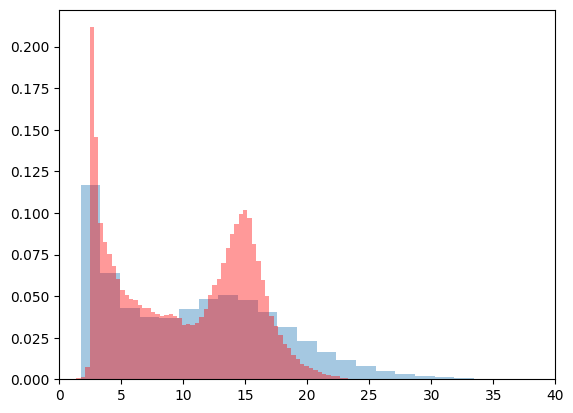

In [83]:
plt.hist(y_test, bins=80, density=True, alpha=.4)
plt.hist(preds, bins=80, color='r', density=True, alpha=.4)
plt.xlim(0,40)
plt.show()

Things to note:
- values do not meet 0m!
- somewhat bimodal distribution
- we did not clip training data--high values will give poor r2 and mse
- we are overpredicting rh98 at 15; we can't match the long right-skewed tail; and tend to miss lower predictions as they are shifted to higher values.

In [125]:
covariates = combined[covariates].to_array().chunk({'x': 256, 'y': 256, 'variable': -1})

In [126]:
def run_predictions(block):
    block = np.array(block)
    xx = block.reshape(len(covariates), -1).T
    xx = xgb.DMatrix(xx)
    preds = bst.predict(xx)
    ex = preds.reshape(1, -1).T.reshape(1, *block.shape[1:])
    return ex

In [133]:
covariates = covariates.compute()

In [134]:
predictions = covariates.map_blocks(run_predictions)

In [135]:
predictions.shape

(1, 27, 4463, 4458)

In [147]:
preds = xr.DataArray(predictions[0], coords=combined[targets].coords)
preds = preds.to_dataset(name='rh98-predictions')

In [148]:
preds.chunk({"time":1, "y":1024,"x": 1024}).to_zarr("../data/predictions.zarr", mode='w')

In [149]:
from geogif import gif

In [151]:
gif(preds['rh98-predictions'], to="../data/predictions.gif", fps=2)